# Extract data within a boundary
In this tutorial we will download a timeseries of environmental data from an ERDDAP server, and then masked the data t retain only the data within an irregular geographical boundary (polygon). Examples of boundaries of marine protected area or marine physical, biological, and ecological provinces. 

## Objective
This tutorial will demonstration how to calculate the sea ice area and extent using sea ice concentration and grid cell area data.  Please visit the  <a href="https://nsidc.org/learn/ask-scientist/what-difference-between-sea-ice-area-and-extent#:~:text=But%20NSIDC%20scientists%2C%20like%20most,the%20total%20in%20their%20entirety.&text=Calculating%20sea%20ice%20extent%20means,with%2015%20percent%20or%20more.">NSIDC website</a> for more detailed descriptions of the calculations. 

## The tutorial demonstrates the following techniques
-   Downloading and saving a netcdf file from PolarWatch ERDDAP data server
-   Accessing satellite data and metadata in polar stereographic projection
-   Downloading and adding grid cell area data to the satellite data
-   Visualizing data on a map
-   Computing sea ice area and extent using sea ice concentration data
-   Plotting a time series of sea ice area and extent

## Datasets used
__NOAA Geo-polar Blended Analysis Sea-Surface Temperature, Global, Daily, 5km, 2019-Present__    
The NOAA geo-polar blended SST is a high resolution satellite-based sea surface temperature (SST) product that combines SST data from US, Japanese and European geostationary infrared imagers, and low-earth orbiting infrared (U.S. and European) SST data, into a single product.  
https://coastwatch.noaa.gov/erddap/griddap/noaacwBLENDEDsstDNDaily

__Longhurst marine provinces__  
The dataset represents the division of the world oceans into provinces as defined by Longhurst (1995; 1998; 2006). The division has been based on the prevailing role of physical forcing as a regulator of phytoplankton distribution. For this tutorial we will use the Gulf Stream province (Code: GFST)  
https://www.marineregions.org/downloads.php
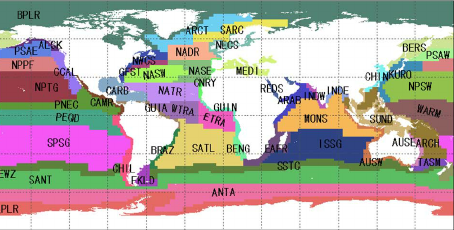

## Import packages

In [24]:
from erddapy import ERDDAP
import matplotlib.pyplot as plt
import matplotlib as mpl
import xarray as xr
import geopandas
import cartopy.crs as ccrs
import regionmask

## Load the Longhurst Provinces shape file into a geopandas dataframe

In [35]:
shape_path = 'shapes/Longhurst_world_v4_2010/Longhurst_world_v4_2010.shp'
shapefiles = geopandas.read_file(shape_path)
shapefiles.head(8)

,ProvCode,ProvDescr,geometry
0,BPLR,Polar - Boreal Polar Province (POLR),"MULTIPOLYGON (((-161.18426 63.50000, -161.5000..."
1,ARCT,Polar - Atlantic Arctic Province,"MULTIPOLYGON (((-21.51305 64.64409, -21.55945 ..."
2,SARC,Polar - Atlantic Subarctic Province,"MULTIPOLYGON (((11.26472 63.96082, 11.09548 63..."
3,NADR,Westerlies - N. Atlantic Drift Province (WWDR),"POLYGON ((-11.50000 57.50000, -11.50000 56.500..."
4,GFST,Westerlies - Gulf Stream Province,"POLYGON ((-43.50000 43.50000, -43.50000 42.500..."
5,NASW,Westerlies - N. Atlantic Subtropical Gyral Pro...,"POLYGON ((-39.50000 25.50000, -40.50000 25.500..."
6,NATR,Trades - N. Atlantic Tropical Gyral Province (...,"MULTIPOLYGON (((-72.34673 18.53597, -72.36877 ..."
7,WTRA,Trades - Western Tropical Atlantic Province,"POLYGON ((-19.50000 -6.50000, -20.50000 -6.500..."


In [37]:
myCode = "GFST"
gulf_stream = shapefiles.loc[shapefiles["ProvCode"] == myCode]
gulf_stream

,ProvCode,ProvDescr,geometry
4,GFST,Westerlies - Gulf Stream Province,"POLYGON ((-43.50000 43.50000, -43.50000 42.500..."


## Find the coordinates of the bounding box
* The bounding box is the smallest rectangle that will completely enclose the province. 
* We will use the bouncing box to subset the satellite data 

In [11]:
gulf_stream.bounds

,minx,miny,maxx,maxy
4,-73.5,33.5,-43.5,43.5


## Open the satellite dataset into a xarray dataset object

In [38]:
ds = xr.open_dataset('https://coastwatch.noaa.gov/erddap/griddap/noaacwBLENDEDsstDNDaily')
ds

<xarray.Dataset>
Dimensions:           (time: 1481, latitude: 3600, longitude: 7200)
Coordinates:
  * time              (time) datetime64[ns] 2019-07-22T12:00:00 ... 2023-08-2...
  * latitude          (latitude) float32 -89.97 -89.93 -89.88 ... 89.93 89.97
  * longitude         (longitude) float32 -180.0 -179.9 -179.9 ... 179.9 180.0
Data variables:
    analysed_sst      (time, latitude, longitude) float32 ...
    analysis_error    (time, latitude, longitude) float32 ...
    sea_ice_fraction  (time, latitude, longitude) float32 ...
    mask              (time, latitude, longitude) float32 ...
Attributes: (12/50)
    acknowledgement:            NOAA/NESDIS
    cdm_data_type:              Grid
    comment:                    The Geo-Polar Blended Sea Surface Temperature...
    Conventions:                CF-1.6, Unidata Observation Dataset v1.0, COA...
    creator_email:              john.sapper@noaa.gov
    creator_name:               Office of Satellite Products and Operations
    ...                         ...
    summary:                    Analysed blended sea surface temperature over...
    testOutOfDate:              now-4days
    time_coverage_end:          2023-08-22T12:00:00Z
    time_coverage_start:        2019-07-22T12:00:00Z
    title:                      Sea-Surface Temperature, NOAA Geo-polar Blend...
    Westernmost_Easting:        -179.975

## Subset the satellite data
* Use the bounding box coordinates for the latitude and longitude slices
* Select the last 5 time steps in teh dataset

In [40]:
ds_subset = ds['analysed_sst'].sel(time=slice(ds.time[-5].values, ds.time[-1].values),
                                   latitude=slice(gulf_stream.bounds.miny.item(), gulf_stream.bounds.maxy.item()),
                                   longitude=slice(gulf_stream.bounds.minx.item(), gulf_stream.bounds.maxx.item())
                                   )
ds_subset

<xarray.DataArray 'analysed_sst' (time: 5, latitude: 200, longitude: 600)>
[600000 values with dtype=float32]
Coordinates:
  * time       (time) datetime64[ns] 2023-08-18T12:00:00 ... 2023-08-22T12:00:00
  * latitude   (latitude) float32 33.53 33.58 33.62 33.67 ... 43.38 43.42 43.47
  * longitude  (longitude) float32 -73.47 -73.43 -73.38 ... -43.62 -43.58 -43.53
Attributes:
    colorBarMaximum:  32.0
    colorBarMinimum:  0.0
    comment:          Analysed SST for each ocean grid point
    ioos_category:    Temperature
    long_name:        analysed sea surface temperature
    references:       Fieguth,P.W. et al. "Mapping Mediterranean altimeter da...
    standard_name:    sea_surface_foundation_temperature
    units:            degree_C
    valid_max:        39.999992
    valid_min:        -2.0000062

## Visualize the unmasked data on a map

Text(0.5, 1.0, 'Satellite Data Before Masking')

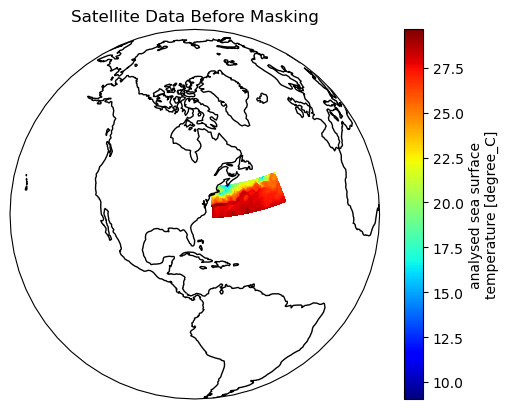

In [48]:
ax = plt.axes(projection=ccrs.Orthographic(-80, 35))
ax.set_global()
ds_subset[-1].plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(), cmap='jet')
ax.coastlines()
plt.title('Satellite Data Before Masking')

#plt.savefig('cartopy_example.png')

## Create the region from the shape file

In [ ]:
region = regionmask.from_geopandas(gulf_stream)
region.plot()



## Mask the satellite data


In [53]:
# Create the mask
mask = region.mask(ds_subset.longitude, ds_subset.latitude)

# Apply mask the the satellite data
masked_ds = ds_subset.where(mask == region.numbers[0])



Text(0.5, 1.0, 'Satellite Data Before Masking')

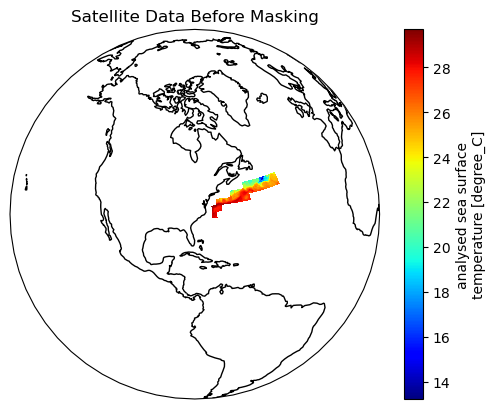

In [57]:
ax = plt.axes(projection=ccrs.Orthographic(-80, 35))
ax.set_global()
masked_ds[0].plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(), cmap='jet')
ax.coastlines()
plt.title('Satellite Data Before Masking')

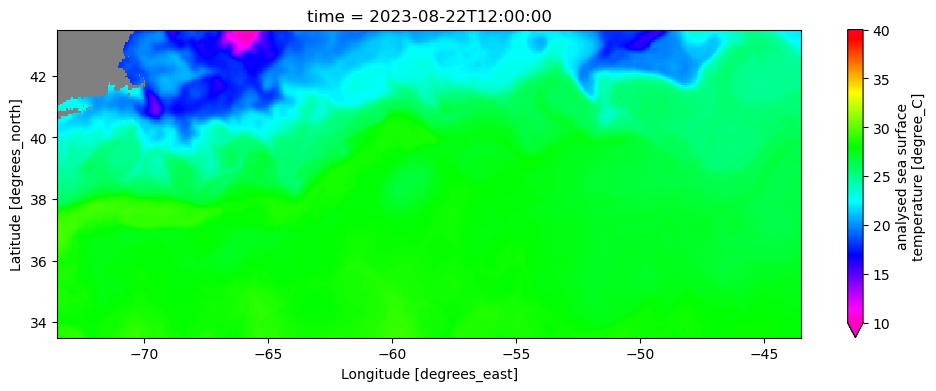

In [15]:
cmap = mpl.cm.get_cmap("gist_rainbow_r").copy()

# Set the color of the missing or masked data 
cmap.set_bad(color='gray')  # missing values color (like land..)

ds_subset[-1].plot.pcolormesh(cmap=cmap,
                          vmin=10,
                          vmax=40,
                          aspect=3,
                          size=4
                          )

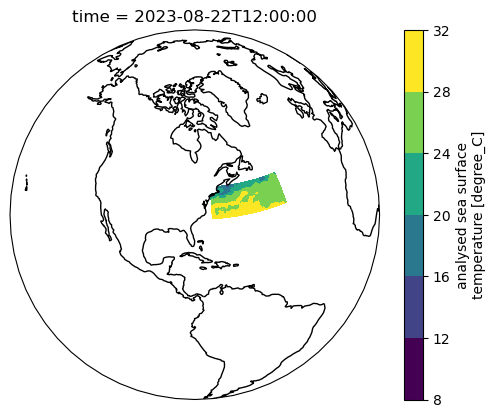

In [18]:
ax = plt.axes(projection=ccrs.Orthographic(-80, 35))
ax.set_global()
ds_subset[-1].plot.contourf(ax=ax, transform=ccrs.PlateCarree())
ax.coastlines()

#plt.savefig('cartopy_example.png')

In [102]:
#list(SA.bounds.miny)
SA.bounds

,minx,miny,maxx,maxy
4,-73.5,33.5,-43.5,43.5


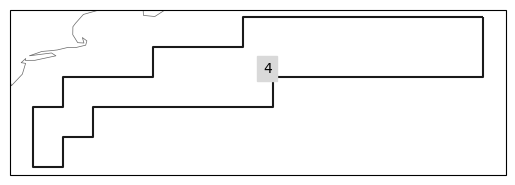

In [49]:

region = regionmask.from_geopandas(gulf_stream)
region.plot()

mask = region.mask(ds_subset.longitude, ds_subset.latitude)

In [31]:

mask = region.mask(ds_subset.longitude, ds_subset.latitude)

In [32]:

dd = ds_subset[0].where(mask == region.numbers[0])
dd



<xarray.DataArray 'analysed_sst' (latitude: 200, longitude: 600)>
array([[28.409994, 28.429995, 28.429995, ...,       nan,       nan,
              nan],
       [28.389994, 28.409994, 28.429995, ...,       nan,       nan,
              nan],
       [28.389994, 28.429995, 28.439995, ...,       nan,       nan,
              nan],
       ...,
       [      nan,       nan,       nan, ..., 22.619993, 22.629993,
        22.649994],
       [      nan,       nan,       nan, ..., 22.419994, 22.409994,
        22.399994],
       [      nan,       nan,       nan, ..., 22.229994, 22.199993,
        22.169994]], dtype=float32)
Coordinates:
    time       datetime64[ns] 2023-08-18T12:00:00
  * latitude   (latitude) float32 33.53 33.58 33.62 33.67 ... 43.38 43.42 43.47
  * longitude  (longitude) float32 -73.47 -73.43 -73.38 ... -43.62 -43.58 -43.53
Attributes:
    colorBarMaximum:  32.0
    colorBarMinimum:  0.0
    comment:          Analysed SST for each ocean grid point
    ioos_category:    Temperature
    long_name:        analysed sea surface temperature
    references:       Fieguth,P.W. et al. "Mapping Mediterranean altimeter da...
    standard_name:    sea_surface_foundation_temperature
    units:            degree_C
    valid_max:        39.999992
    valid_min:        -2.0000062

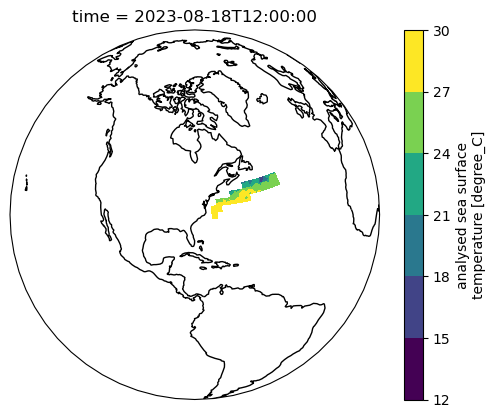

In [33]:
ax = plt.axes(projection=ccrs.Orthographic(-80, 35))
ax.set_global()
dd.plot.contourf(ax=ax, transform=ccrs.PlateCarree())
ax.coastlines()

In [ ]:
ax = plt.axes(projection=ccrs.Orthographic(-80, 35))
ax.set_global()
dd.plot.contourf(ax=ax, transform=ccrs.PlateCarree())
ax.coastlines()

In [100]:


ds_subset = ds2['analysed_sst'].sel(time=slice(ds2.time[-5].values, ds2.time[-1].values),
                                    latitude=slice(SA.bounds.miny.item(), SA.bounds.maxy.item()),
                                    longitude=slice(SA.bounds.minx.item(), SA.bounds.maxx.item())
                                    )
ds_subset

<xarray.DataArray 'analysed_sst' (time: 5, latitude: 200, longitude: 600)>
[600000 values with dtype=float32]
Coordinates:
  * time       (time) datetime64[ns] 2023-08-13T12:00:00 ... 2023-08-17T12:00:00
  * latitude   (latitude) float32 33.53 33.58 33.62 33.67 ... 43.38 43.42 43.47
  * longitude  (longitude) float32 -73.47 -73.43 -73.38 ... -43.62 -43.58 -43.53
Attributes:
    colorBarMaximum:  32.0
    colorBarMinimum:  0.0
    comment:          Analysed SST for each ocean grid point
    ioos_category:    Temperature
    long_name:        analysed sea surface temperature
    references:       Fieguth,P.W. et al. "Mapping Mediterranean altimeter da...
    standard_name:    sea_surface_foundation_temperature
    units:            degree_C
    valid_max:        39.999992
    valid_min:        -2.0000062

In [90]:
# plot
ds_subset

numpy.datetime64('2023-08-17T12:00:00.000000000')

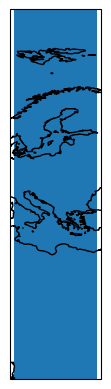

In [103]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt


fig, ax = plt.subplots(subplot_kw={"projection": ccrs.PlateCarree()})

ds_subset.plot(ax=ax)

ax.coastlines();

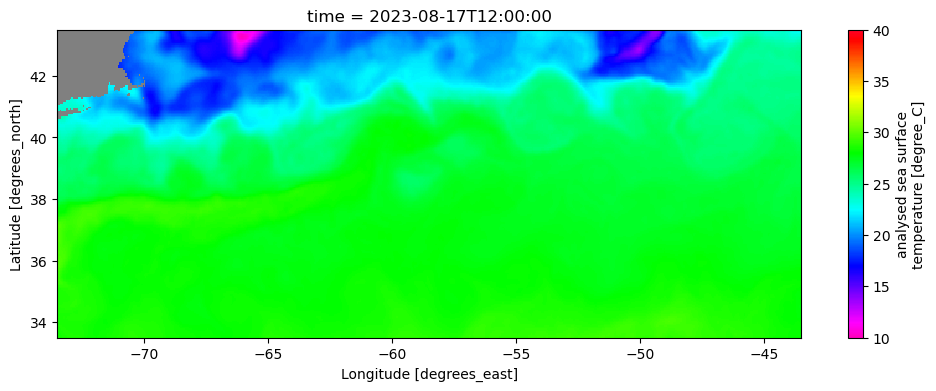

In [113]:
# Create the color palette
cmap = mpl.cm.get_cmap("gist_rainbow_r").copy()

# Set the color of the missing or masked data 
cmap.set_bad(color='gray')  # missing values color (like land..)

ds_subset[-1].plot.pcolormesh(cmap=cmap,
                          vmin=10,
                          vmax=40,
                          aspect=3,
                          size=4
                          )

Text(0.5, 1.0, 'Satellite Data before Masking')

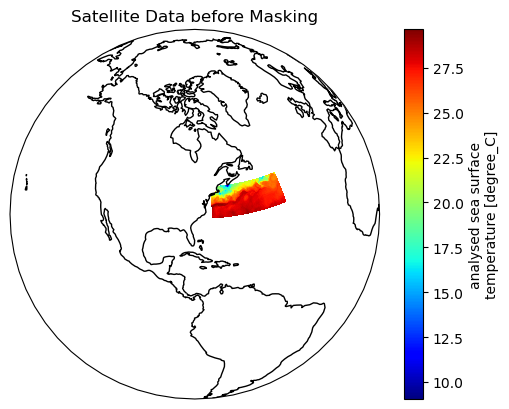

In [46]:
import cartopy.crs as ccrs


ax = plt.axes(projection=ccrs.Orthographic(-80, 35))
ax.set_global()
ds_subset[-1].plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(), cmap='jet')
ax.coastlines()
plt.title('Satellite Data Before Masking')

#plt.savefig('cartopy_example.png')

In [26]:
region = regionmask.from_geopandas(GM, name=name)
region.plot()

NameError: name 'GM' is not defined

In [134]:
ds["latitude"].values

(727,)

In [136]:
mask = region.mask(
    ds_subset,
    lon_name="longitude",
    lat_name="latitude",
    method="shapely",
)

dd = ds_subset[0].where(mask == region.numbers[0])
dd

ax = plt.axes(projection=ccrs.Orthographic(-80, 35))
ax.set_global()
dd.plot.contourf(ax=ax, transform=ccrs.PlateCarree())
ax.coastlines()


/Users/dalerobinson/miniconda3/envs/py310/lib/python3.10/site-packages/regionmask/core/mask.py:166: FutureWarning: Passing 'lon_name' and 'lat_name' is deprecated. Please pass the lon and lat coordinates direcly, e.g., `mask*(ds[lon_name], ds[lat_name])`.
  warnings.warn(
/var/folders/5b/wxh4r_m176v1dgsf4n8wcf100000gp/T/ipykernel_2083/4207569621.py:1: FutureWarning: The ``method`` argument is internal and  will be removed in the future. Setting the ``method`` (i.e. backend) should not be necessary. Please raise an issue if you require it.
  mask = region.mask(


In [139]:
dd = ds_subset[0].where(mask == region.numbers[0])
dd

<xarray.DataArray 'analysed_sst' (latitude: 200, longitude: 600)>
array([[28.129993, 28.119993, 28.099995, ...,       nan,       nan,
              nan],
       [28.109993, 28.109993, 28.079994, ...,       nan,       nan,
              nan],
       [28.109993, 28.099995, 28.079994, ...,       nan,       nan,
              nan],
       ...,
       [      nan,       nan,       nan, ..., 24.159994, 24.109993,
        24.069994],
       [      nan,       nan,       nan, ..., 24.059994, 23.999994,
        23.939995],
       [      nan,       nan,       nan, ..., 23.909994, 23.829994,
        23.739994]], dtype=float32)
Coordinates:
    time       datetime64[ns] 2023-08-13T12:00:00
  * latitude   (latitude) float32 33.53 33.58 33.62 33.67 ... 43.38 43.42 43.47
  * longitude  (longitude) float32 -73.47 -73.43 -73.38 ... -43.62 -43.58 -43.53
Attributes:
    colorBarMaximum:  32.0
    colorBarMinimum:  0.0
    comment:          Analysed SST for each ocean grid point
    ioos_category:    Temperature
    long_name:        analysed sea surface temperature
    references:       Fieguth,P.W. et al. "Mapping Mediterranean altimeter da...
    standard_name:    sea_surface_foundation_temperature
    units:            degree_C
    valid_max:        39.999992
    valid_min:        -2.0000062

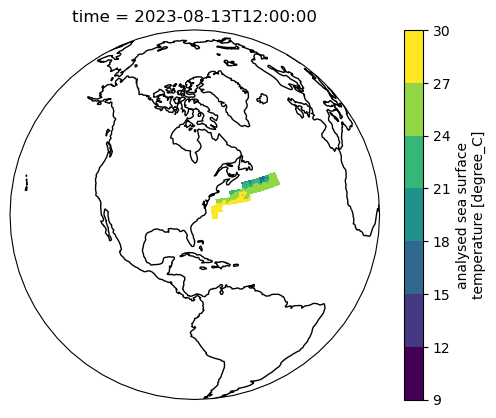

In [140]:
ax = plt.axes(projection=ccrs.Orthographic(-80, 35))
ax.set_global()
dd.plot.contourf(ax=ax, transform=ccrs.PlateCarree())
ax.coastlines()

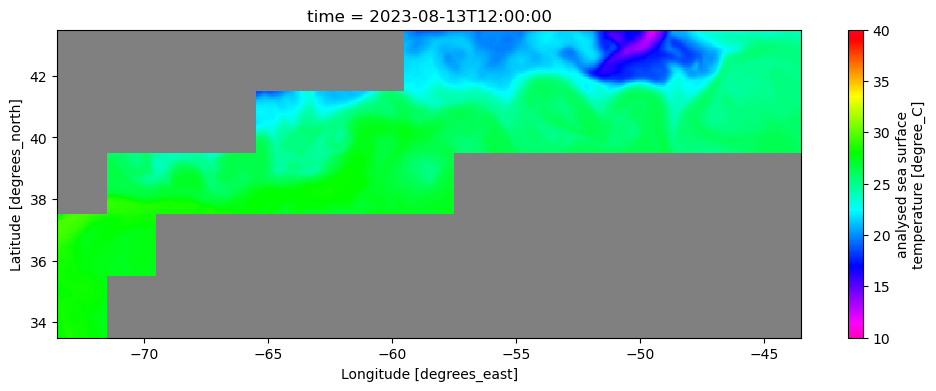

In [142]:
cmap = mpl.cm.get_cmap("gist_rainbow_r").copy()

# Set the color of the missing or masked data 
cmap.set_bad(color='gray')  # missing values color (like land..)

dd.plot.pcolormesh(cmap=cmap,
                          vmin=10,
                          vmax=40,
                          aspect=3,
                          size=4
                          )

In [128]:
mask = region.mask(
    ds.values,
    ds.longitude.values,
    ds.latitude.values,
    method="shapely",
)

#mask*(ds.longitude.values, ds.latitude.values)

/var/folders/5b/wxh4r_m176v1dgsf4n8wcf100000gp/T/ipykernel_2083/3782214185.py:1: FutureWarning: Passing 'lon_name' as positional argument(s) to mask was deprecated in version 0.10.0 and will raise an error two releases later. Please pass them as keyword arguments.
  mask = region.mask(


TypeError: '<' not supported between instances of 'method' and 'int'

In [ ]:
fig, ax = plt.subplots(subplot_kw={"projection": ccrs.PlateCarree()})
ds["ROSE"].where(mask == region.numbers[0]).plot(ax=ax)
ax.coastlines();

In [67]:
e.griddap_initialize()

In [68]:
pprint.pprint(e.variables)

['analysed_sst', 'analysis_error', 'sea_ice_fraction', 'mask']


In [69]:
pprint.pprint(e.constraints)

{'latitude<=': 89.975,
 'latitude>=': -89.975,
 'latitude_step': 1,
 'longitude<=': 179.975,
 'longitude>=': -179.975,
 'longitude_step': 1,
 'time<=': '2023-08-17T12:00:00Z',
 'time>=': '2023-08-17T12:00:00Z',
 'time_step': 1}


In [70]:
print(f"Variables in this dataset:\n\n{e.variables}")
print(
    f"\nRanges of the coodinate variables:\n\n{json.dumps(e.constraints, indent=1)}"
)

Variables in this dataset:

['analysed_sst', 'analysis_error', 'sea_ice_fraction', 'mask']

Ranges of the coodinate variables:

{
 "time>=": "2023-08-17T12:00:00Z",
 "time<=": "2023-08-17T12:00:00Z",
 "time_step": 1,
 "latitude>=": -89.975,
 "latitude<=": 89.975,
 "latitude_step": 1,
 "longitude>=": -179.975,
 "longitude<=": 179.975,
 "longitude_step": 1
}


In [ ]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt


fig, ax = plt.subplots(subplot_kw={"projection": ccrs.PlateCarree()})

ds["ROSE"].plot(ax=ax)

ax.coastlines();

In [78]:
%%time


UsageError: %%time is a cell magic, but the cell body is empty. Did you mean the line magic %time (single %)?


In [205]:
shape_path2 = 'shapes/MPA/MPA_Inventory_Sites_March_2010.shp'
shapefile2 = geopandas.read_file(shape_path2)


In [214]:
shapefile2

,Site_ID,Area_KM,Site_Name,Gov_Level,NS_Full,Prot_Lvl,Mgmt_Plan,Mgmt_Agen,Fish_Rstr,Pri_Con_Fo,...,Permanence,Constancy,Estab_Yr,URL,Site_Label,Vessel,Anchor,Shape_Leng,Shape_Area,geometry
0,AK1,3448.330,Southeast Alaska Dive Fishery Research Areas,State,Eligible,Uniform Multiple Use,Non-MPA Programmatic Species Management Plan,Alaska Department of Fish and Game,Commercial Fishing Restricted,Sustainable Production,...,Permanent,Year-round,1991,NaN,SE AK Dive Fishery Research Areas,NaN,NaN,57.947463,0.516915,"MULTIPOLYGON (((-132.74958 54.98909, -132.7498..."
1,AK10,710.554,Sitka Sound Lingcod Closure,State,Eligible,Uniform Multiple Use,Non-MPA Programmatic Fisheries Management Plan,Alaska Department of Fish and Game,Commercial Fishing Restricted,Sustainable Production,...,Permanent,Year-round,1997,NaN,Sitka Snd. Lingcod Closure,NaN,NaN,12.111787,0.105387,"MULTIPOLYGON (((-135.71462 57.37251, -135.7149..."
2,AK11,37448.800,Black Rockfish Closure Areas,State,Eligible,Uniform Multiple Use,Non-MPA Programmatic Fisheries Management Plan,Alaska Department of Fish and Game,Commercial Fishing Restricted,Sustainable Production,...,Permanent,Year-round,1997,NaN,Black Rockfish CAs,NaN,NaN,213.775947,5.471697,"MULTIPOLYGON (((-133.03517 54.85467, -133.0131..."
3,AK12,2257.500,Demersal Shelf Rockfish Closed Area - Southeas...,State,Eligible,Uniform Multiple Use,Non-MPA Programmatic Fisheries Management Plan,Alaska Department of Fish and Game,Commercial Fishing Restricted,Sustainable Production,...,Permanent,Year-round,1997,NaN,DSRCA - SE AK,NaN,NaN,32.839339,0.325394,"MULTIPOLYGON (((-131.60117 55.10031, -131.6032..."
4,AK13,2238.420,Shrimp Trawl Fishery Closure - Southeast Alaska,State,Eligible,Uniform Multiple Use,Non-MPA Programmatic Fisheries Management Plan,Alaska Department of Fish and Game,Commercial Fishing Restricted,Sustainable Production,...,Permanent,Year-round,1997,NaN,Shrimp Trawl FC - SE AK,NaN,NaN,25.251183,0.346685,"MULTIPOLYGON (((-132.65326 55.48883, -132.6527..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1447,CA88,0.000,Point Reyes Headlands State Marine Conservatio...,State,Eligible,Uniform Multiple Use,MPA Programmatic Management Plan,California Department of Fish and Game,Commercial Fishing Restricted and Recreational...,Natural Heritage,...,Permanent,Year-round,1972,NaN,Point Reyes Headlands SMCA,Unrestricted,Unrestricted,0.161235,0.000211,"POLYGON ((-123.02421 37.99551, -123.02424 37.9..."
1448,CA89,0.000,Estero de Limantour State Marine Conservation ...,State,Eligible,Uniform Multiple Use,MPA Programmatic Management Plan,California Department of Fish and Game,Commercial Fishing Restricted and Recreational...,Natural Heritage,...,Permanent,Year-round,1971,NaN,Estero de Limantour SMCA,NaN,NaN,0.163245,0.000229,"POLYGON ((-122.93165 38.03528, -122.93139 38.0..."
1449,CA86,0.000,Duxbury Reef State Marine Conservation Area,State,Eligible,Uniform Multiple Use,MPA Programmatic Management Plan,California Department of Fish and Game,Commercial and Recreational Fishing Restricted,Natural Heritage,...,Permanent,Year-round,1971,NaN,Duxbury Reef SMCA,Unrestricted,Unrestricted,0.122240,0.000176,"POLYGON ((-122.70040 37.89622, -122.70033 37.8..."
1450,CA134,0.000,Farallon Islands State Marine Conservation Area,State,Eligible,Zoned Multiple Use,MPA Programmatic Management Plan,California Department of Fish and Game,Commercial and Recreational Fishing Restricted,Natural Heritage,...,Permanent,Year-round,1991,NaN,Farallon Islands SMCA,Restricted,Restricted,0.306590,0.003575,"MULTIPOLYGON (((-123.11458 37.78793, -123.1132..."


In [229]:
myCode = "Southern Nearshore Trap/Pot Waters"
NE = shapefile2.loc[shapefile2["Site_Name"] == myCode]

<GeoAxesSubplot:>

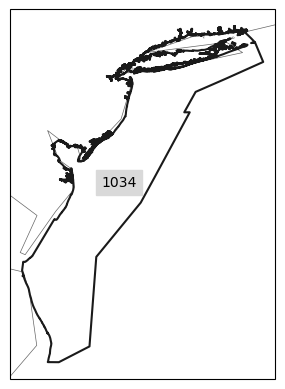

In [230]:
region = regionmask.from_geopandas(NE, name=name)
region.plot()

In [231]:
ds_subset2 = ds2['analysed_sst'].sel(time=slice(ds2.time[-5].values, ds2.time[-1].values),
                                    latitude=slice(NE.bounds.miny.item(), NE.bounds.maxy.item()),
                                    longitude=slice(NE.bounds.minx.item(), NE.bounds.maxx.item())
                                    )
ds_subset2

<xarray.DataArray 'analysed_sst' (time: 5, latitude: 123, longitude: 89)>
[54735 values with dtype=float32]
Coordinates:
  * time       (time) datetime64[ns] 2023-08-13T12:00:00 ... 2023-08-17T12:00:00
  * latitude   (latitude) float32 35.28 35.33 35.38 35.42 ... 41.28 41.33 41.38
  * longitude  (longitude) float32 -75.97 -75.93 -75.88 ... -71.68 -71.62 -71.57
Attributes:
    colorBarMaximum:  32.0
    colorBarMinimum:  0.0
    comment:          Analysed SST for each ocean grid point
    ioos_category:    Temperature
    long_name:        analysed sea surface temperature
    references:       Fieguth,P.W. et al. "Mapping Mediterranean altimeter da...
    standard_name:    sea_surface_foundation_temperature
    units:            degree_C
    valid_max:        39.999992
    valid_min:        -2.0000062

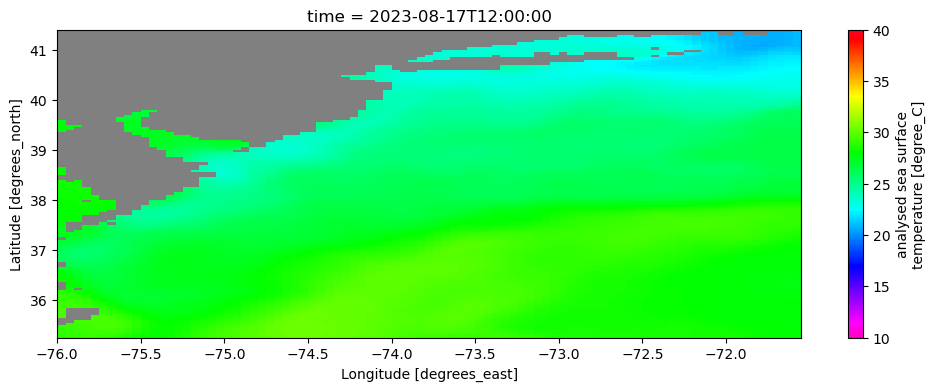

In [232]:
# Create the color palette
cmap = mpl.cm.get_cmap("gist_rainbow_r").copy()

# Set the color of the missing or masked data 
cmap.set_bad(color='gray')  # missing values color (like land..)

ds_subset2[-1].plot.pcolormesh(cmap=cmap,
                          vmin=10,
                          vmax=40,
                          aspect=3,
                          size=4
                          )

/Users/dalerobinson/miniconda3/envs/py310/lib/python3.10/site-packages/regionmask/core/mask.py:166: FutureWarning: Passing 'lon_name' and 'lat_name' is deprecated. Please pass the lon and lat coordinates direcly, e.g., `mask*(ds[lon_name], ds[lat_name])`.
  warnings.warn(
/var/folders/5b/wxh4r_m176v1dgsf4n8wcf100000gp/T/ipykernel_2083/1718095940.py:1: FutureWarning: The ``method`` argument is internal and  will be removed in the future. Setting the ``method`` (i.e. backend) should not be necessary. Please raise an issue if you require it.
  mask = region.mask(


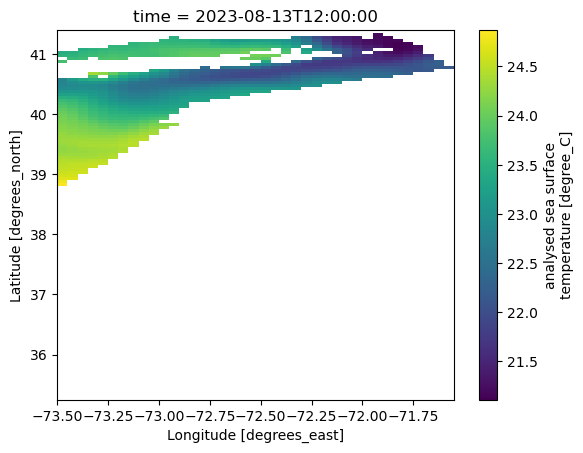

In [236]:
mask = region.mask(
    ds_subset,
    lon_name="longitude",
    lat_name="latitude",
    method="shapely",
)

dd = ds_subset2[0].where(mask == region.numbers[0])
dd.plot()

#ax = plt.axes(projection=ccrs.Orthographic(-80, 35))
#ax.set_global()
#dd.plot.contourf(ax=ax, transform=ccrs.PlateCarree())
#ax.coastlines()

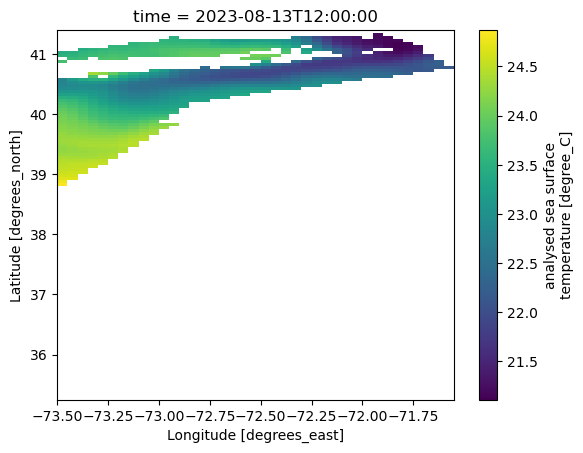

In [238]:
dd = ds_subset2[0].where(mask == region.numbers[0])
dd.plot()

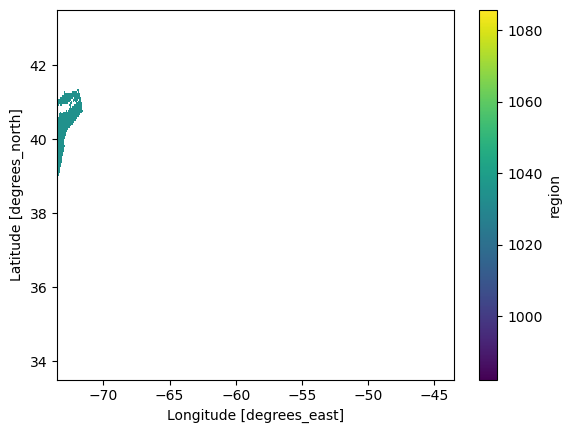

In [239]:
mask.plot()

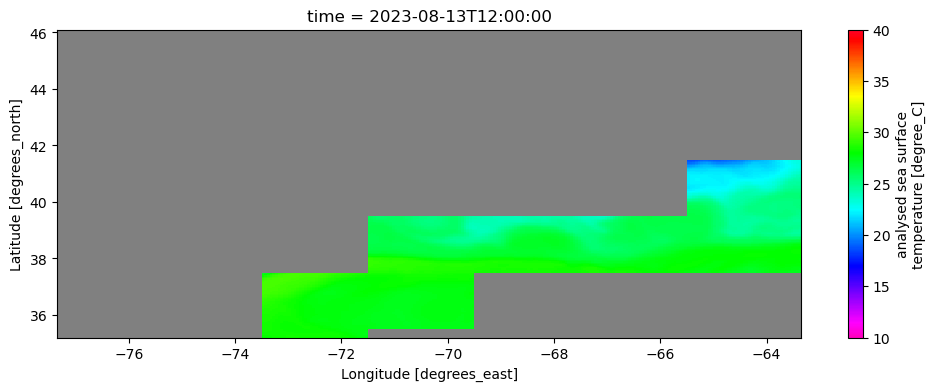

In [178]:
dd.plot.pcolormesh(cmap=cmap,
                          vmin=10,
                          vmax=40,
                          aspect=3,
                          size=4
                          )

/Users/dalerobinson/miniconda3/envs/py310/lib/python3.10/site-packages/regionmask/core/mask.py:166: FutureWarning: Passing 'lon_name' and 'lat_name' is deprecated. Please pass the lon and lat coordinates direcly, e.g., `mask*(ds[lon_name], ds[lat_name])`.
  warnings.warn(
/var/folders/5b/wxh4r_m176v1dgsf4n8wcf100000gp/T/ipykernel_2083/1187554849.py:1: FutureWarning: The ``method`` argument is internal and  will be removed in the future. Setting the ``method`` (i.e. backend) should not be necessary. Please raise an issue if you require it.
  mask = region.mask(


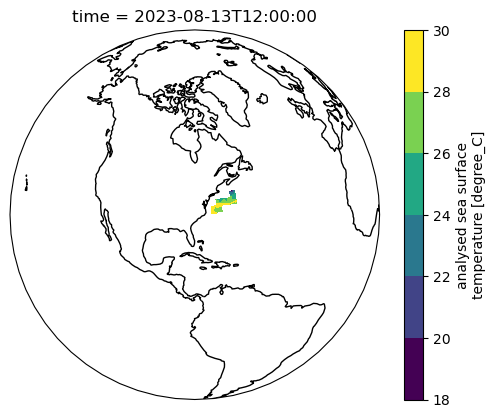

In [177]:
mask = region.mask(
    ds_subset2,
    lon_name="longitude",
    lat_name="latitude",
    method="shapely",
)

dd = ds_subset2[0].where(mask == region.numbers[0])
dd

ax = plt.axes(projection=ccrs.Orthographic(-80, 35))
ax.set_global()
dd.plot.contourf(ax=ax, transform=ccrs.PlateCarree())
ax.coastlines()


In [227]:
region.mask.plot()

AttributeError: 'function' object has no attribute 'plot'

In [31]:
shape_path = 'shapes/Longhurst_world_v4_2010/Longhurst_world_v4_2010.shp'
shapefile = geopandas.read_file(shape_path)

In [40]:
myCode = "GFST"
GM = shapefile.loc[shapefile["ProvCode"] == myCode]

In [41]:
GM.bounds

,minx,miny,maxx,maxy
4,-73.5,33.5,-43.5,43.5


In [146]:
shapefile

,ProvCode,ProvDescr,geometry
0,BPLR,Polar - Boreal Polar Province (POLR),"MULTIPOLYGON (((-161.18426 63.50000, -161.5000..."
1,ARCT,Polar - Atlantic Arctic Province,"MULTIPOLYGON (((-21.51305 64.64409, -21.55945 ..."
2,SARC,Polar - Atlantic Subarctic Province,"MULTIPOLYGON (((11.26472 63.96082, 11.09548 63..."
3,NADR,Westerlies - N. Atlantic Drift Province (WWDR),"POLYGON ((-11.50000 57.50000, -11.50000 56.500..."
4,GFST,Westerlies - Gulf Stream Province,"POLYGON ((-43.50000 43.50000, -43.50000 42.500..."
5,NASW,Westerlies - N. Atlantic Subtropical Gyral Pro...,"POLYGON ((-39.50000 25.50000, -40.50000 25.500..."
6,NATR,Trades - N. Atlantic Tropical Gyral Province (...,"MULTIPOLYGON (((-72.34673 18.53597, -72.36877 ..."
7,WTRA,Trades - Western Tropical Atlantic Province,"POLYGON ((-19.50000 -6.50000, -20.50000 -6.500..."
8,ETRA,Trades - Eastern Tropical Atlantic Province,"POLYGON ((9.50000 -12.50000, 8.50000 -12.50000..."
9,SATL,Trades - South Atlantic Gyral Province (SATG),"POLYGON ((-19.50000 -6.50000, -18.50000 -6.500..."


In [6]:
import geopandas
import pooch


url = "https://naturalearth.s3.amazonaws.com/4.1.1/50m_physical/ne_50m_geography_marine_polys.zip"
fname = pooch.retrieve(
    url,
    known_hash="db6f59e5a747c016451caec2450db6deea25d702dc2fb9c39384c1b909fb7f72",
)

oceans = geopandas.read_file(fname)
name = "South Atlantic Ocean"
SA = oceans.loc[oceans["name"] == name]

In [28]:
SA.bounds

,minx,miny,maxx,maxy
18,-97.857587,20.799997,-79.895557,30.694354


In [29]:
import json

e.griddap_initialize()

print(f"variables in this dataset:\n\n{e.variables}")
print(
    f"\nconstraints of this dataset:\n\n{json.dumps(e.constraints, indent=1)}"
)

variables in this dataset:

['ROSE']

constraints of this dataset:

{
 "latitude>=": -60.53346241642455,
 "latitude<=": 0.03286652261984102,
 "latitude_step": 1,
 "longitude>=": -69.09208207871731,
 "longitude<=": 19.63485354989288,
 "longitude_step": 1
}


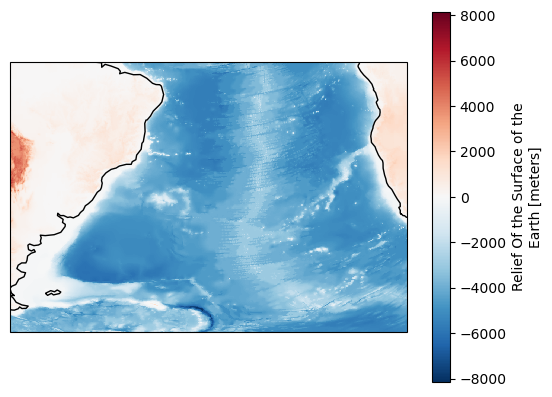

In [13]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt


fig, ax = plt.subplots(subplot_kw={"projection": ccrs.PlateCarree()})

ds["ROSE"].plot(ax=ax)

ax.coastlines();

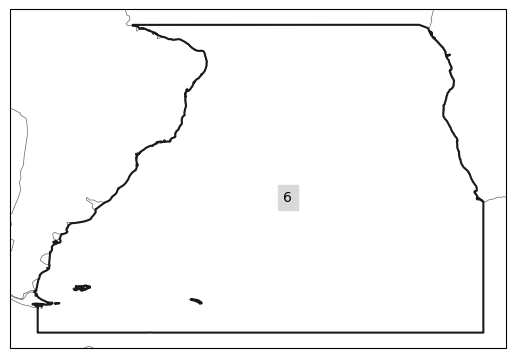

In [14]:
import regionmask


region = regionmask.from_geopandas(SA, name=name)
region.plot()

/Users/dalerobinson/miniconda3/envs/py310/lib/python3.10/site-packages/regionmask/core/mask.py:166: FutureWarning: Passing 'lon_name' and 'lat_name' is deprecated. Please pass the lon and lat coordinates direcly, e.g., `mask*(ds[lon_name], ds[lat_name])`.
  warnings.warn(
/var/folders/5b/wxh4r_m176v1dgsf4n8wcf100000gp/T/ipykernel_2083/347221932.py:1: FutureWarning: The ``method`` argument is internal and  will be removed in the future. Setting the ``method`` (i.e. backend) should not be necessary. Please raise an issue if you require it.
  mask = region.mask(


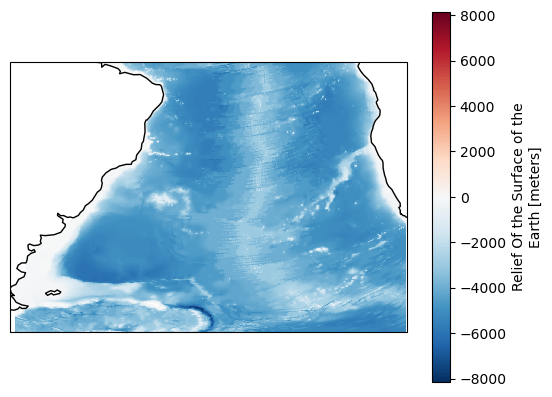

In [15]:
mask = region.mask(
    ds,
    lon_name="longitude",
    lat_name="latitude",
    method="shapely",
)


fig, ax = plt.subplots(subplot_kw={"projection": ccrs.PlateCarree()})
ds["ROSE"].where(mask == region.numbers[0]).plot(ax=ax)
ax.coastlines();


# conda install -c conda-forge regionmask=0.10.0 cartopy

In [ ]:
region = regionmask.from_geopandas(GM, name=name)
region.plot()